In [11]:
#Reading Data
import json
import numpy as np
import pandas as pd   
ice = pd.read_json('train.json')
test = pd.read_json('test.json')

In [12]:
ice.inc_angle = ice.inc_angle.replace('na', 0)
ice.inc_angle = ice.inc_angle.astype(float).fillna(0.0)

In [13]:
band1 = []
band2 = []

for i in range(1604):
    band1.append(np.reshape(ice.iloc[i,0],(75,75)))
    band2.append(np.reshape(ice.iloc[i,1],(75,75)))



In [14]:
test_band1 = []
test_band2 = []

for i in range(8424):
    test_band1.append(np.reshape(test.iloc[i,0],(75,75)))
    test_band2.append(np.reshape(test.iloc[i,1],(75,75)))

In [15]:

band1 = np.array(band1,dtype='f')
band2 = np.array(band2,dtype='f')
test_band1 = np.array(test_band1,dtype='f')
test_band2 = np.array(test_band2,dtype='f')

In [16]:
#Addition of both bands
new_band = []
for i in range(1604):
    new_band.append((band1[i] +band2[i])/2)
new_band = np.array(new_band,dtype='f')
new_band.shape

(1604, 75, 75)

In [17]:
test_new_band=[]
for i in range(8424):
    test_new_band.append((test_band1[i] + test_band2[i])/2)
test_new_band = np.array(test_new_band,dtype='f')
test_new_band.shape

(8424, 75, 75)

In [18]:
#Changing Sign

for i in range(1604):
    new_band[i] = np.negative(new_band[i])
    band1[i] = np.negative(band1[i])
    band2[i] = np.negative(band2[i])
for i in range(8424):
    test_new_band[i] = np.negative(test_new_band[i])
    test_band1[i] = np.negative(test_band1[i])
    test_band2[i] = np.negative(test_band2[i])

In [19]:
#Subtracting each column of each pixel by the max value
for i in range(1604):
    for j in range(75):
        new_band[i][j] = np.max(new_band[i][j]) - new_band[i][j]
        band1[i][j] = np.max(band1[i][j]) - band1[i][j]
        band2[i][j] = np.max(band2[i][j]) - band2[i][j]
for i in range(8424):
    for j in range(75):
        test_new_band[i][j] = np.max(test_new_band[i][j]) - test_new_band[i][j]
        test_band1[i][j] = np.max(test_band1[i][j]) - test_band1[i][j]
        test_band2[i][j] = np.max(test_band2[i][j]) - test_band2[i][j]

In [20]:
from sklearn.preprocessing import normalize
for i in range(1604):
    new_band[i] = normalize(new_band[i], axis=1, norm='l2')
    band1[i] = normalize(band1[i],axis=1,norm='l2')
    band2[i] = normalize(band2[i],axis=1,norm='l2')
for i in range(1604):
    test_new_band[i] = normalize(test_new_band[i], axis=1, norm='l1')
    test_band1[i] = normalize(test_band1[i], axis=1, norm='l1')
    test_band2[i] = normalize(test_band2[i], axis=1, norm='l1')

In [21]:
#Stacking the bands on top of each other
vertical_stack=[]
for i in range(1604):
     vertical_stack.append(np.vstack(([band1[i]],[band2[i]],[new_band[i]])))
vertical_stack = np.array(vertical_stack)

In [116]:
vertical_stack.shape

(1604, 3, 75, 75)

In [12]:
#Stacking the bands on top of each other
vertical_stack_test=[]
for i in range(8424):
    vertical_stack_test.append(np.vstack(([median_test1[i]],[median_test2[i]],[median_test3[i]])))
vertical_stack_test = np.array(vertical_stack_test)

NameError: name 'median_test1' is not defined

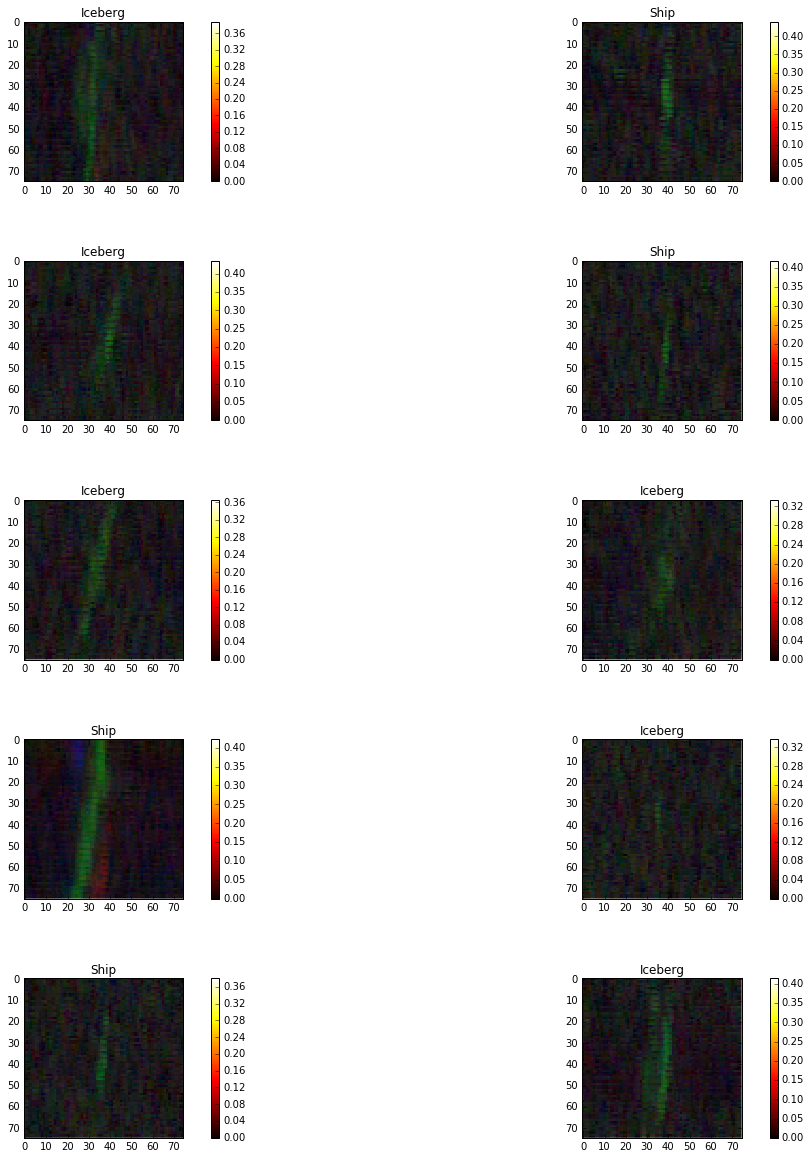

In [118]:
import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt
import random

#Sample images
sample=[]
for i in range(1604):
    sample.append(np.hstack((band1[i],band2[i],new_band[i])))
sample = np.array(sample)
sample = sample.reshape(1604,3,75,75).transpose(0,2,3,1).astype("float")
#Randomly generate 10 unique numbers from the range of 0-1604
random_int = random.sample(range(0,1604),10)
object_class = np.array(ice.iloc[random_int,4])
class_label=[]
for i in range(len(object_class)):
    if object_class[i] == 0:
        class_label.append("Ship")
    else:
        class_label.append("Iceberg")
i=0
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace = 0.5, wspace=.001)

for image in random_int:
    ax = fig.add_subplot(5,2,i+1)
    im = plt.imshow(sample[image],cmap='hot', interpolation='none')
    #ax.imshow(new_band[image], cmap='hot', interpolation='none')
    plt.title(class_label[i])
    i+=1
    cbar = plt.colorbar(im)
plt.savefig("RGB")

In [22]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

np.random.seed(1000)
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(3,75,75),padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32,( 3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32,( 3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.25))
model.add(GlobalMaxPooling2D())
#model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(vertical_stack[:802],np_utils.to_categorical(ice.iloc[:802,4]),validation_data=(vertical_stack[802:],np_utils.to_categorical(ice.iloc[802:,4])), 
          batch_size=32, nb_epoch=100, verbose=1,shuffle = True)

/u/vmagadi/anaconda/lib/python2.7/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 802 samples, validate on 802 samples
Epoch 1/100
802/802 [==============================] - 25s - loss: 0.6910 - acc: 0.5137 - val_loss: 0.6933 - val_acc: 0.4377
Epoch 2/100
802/802 [==============================] - 22s - loss: 0.6819 - acc: 0.5561 - val_loss: 0.6800 - val_acc: 0.5224
Epoch 3/100
802/802 [==============================] - 21s - loss: 0.6448 - acc: 0.6471 - val_loss: 0.5904 - val_acc: 0.7307
Epoch 4/100
802/802 [==============================] - 21s - loss: 0.5673 - acc: 0.7282 - val_loss: 0.5204 - val_acc: 0.7668
Epoch 5/100
802/802 [==============================] - 21s - loss: 0.5564 - acc: 0.7157 - val_loss: 0.5251 - val_acc: 0.7544
Epoch 6/100
802/802 [==============================] - 21s - loss: 0.4856 - acc: 0.7756 - val_loss: 0.4867 - val_acc: 0.7668
Epoch 7/100
802/802 [==============================] - 19s - loss: 0.4484 - acc: 0.8067 - val_loss: 0.4732 - val_acc: 0.7656
Epoch 8/100
802/802 [==============================] - 20s - loss: 0.4350 - acc

802/802 [==============================] - 15s - loss: 0.0055 - acc: 1.0000 - val_loss: 0.4991 - val_acc: 0.8753
Epoch 66/100
802/802 [==============================] - 15s - loss: 0.0037 - acc: 1.0000 - val_loss: 0.4633 - val_acc: 0.8716
Epoch 67/100
802/802 [==============================] - 15s - loss: 0.0030 - acc: 1.0000 - val_loss: 0.4570 - val_acc: 0.8791
Epoch 68/100
802/802 [==============================] - 15s - loss: 0.0037 - acc: 1.0000 - val_loss: 0.4924 - val_acc: 0.8716
Epoch 69/100
802/802 [==============================] - 15s - loss: 0.0033 - acc: 1.0000 - val_loss: 0.4609 - val_acc: 0.8778
Epoch 70/100
802/802 [==============================] - 15s - loss: 0.0028 - acc: 1.0000 - val_loss: 0.4693 - val_acc: 0.8766
Epoch 71/100
802/802 [==============================] - 15s - loss: 0.0023 - acc: 1.0000 - val_loss: 0.4823 - val_acc: 0.8778
Epoch 72/100
802/802 [==============================] - 15s - loss: 0.0053 - acc: 1.0000 - val_loss: 0.4693 - val_acc: 0.8703
Epoch

In [2]:
import numpy as np

In [62]:
final_prediction = model.predict_proba(vertical_stack_test,verbose=1)


8424/8424 [==============================] - 72s    


In [63]:
result=pd.read_csv('sample_iceberg.csv')
predi = pd.DataFrame(final_prediction)
nresult=pd.DataFrame()
nresult['id'] = test['id']
nresult['is_iceberg'] = predi.iloc[:,1]
nresult.to_csv('result.csv', index=False)


'"predi.columns=[\'0\',\'is_iceberg\']\nresult.iloc[:,1] = predi.iloc[:,1]\nprint(result)'